In [1]:
import numpy  as np
import pandas as pd
import data_tools
import matplotlib.pyplot as plt

from matplotlib import cm
from scipy.stats import norm
from Models.models import *
from time import time

## Some functions 

In [2]:
ts = pd.read_csv('Preprocessed_data/ts.csv')

log_diff_prices = ts.price.values
log_diff_prices = np.array(log_diff_prices, dtype=float)
log_diff_prices = np.diff(np.log(log_diff_prices))
log_diff_prices = np.concatenate((np.array([0]), log_diff_prices))
ts['log_diff_prices'] = log_diff_prices

yearmonth = list(ts['yearmonth'])
x_label   = data_tools.from_index_to_dates(yearmonth)

ts['X'] = np.zeros(ts.shape[0])

for t in ts.index:
    if t == 0:
        continue
        
    curr_price = ts.loc[t  , 'price']
    prev_price = ts.loc[t-1, 'price'] 
    
    ts.loc[t,'X'] = residual(prev_price,curr_price,t)

eta = 0.5
zd  = 105.69451612903225
r   = 0.0041

discount = 1/(1+r)

elev_stor = zip(ts.elevation.values,ts.storage.values)
elev_stor = sorted(elev_stor, key=lambda x: (x[1],x[0]))

def get_middle_points(x):
    x = np.array(x)
    return (x[:-1] + x[1:])/2


def pi_fun(storage, inflow, t, P, q, model_inflow, model_evaporation):
    
    expected_storage = model_storage(model_inflow, inflow , model_evaporation, t, storage, q) # this may not be needed if forecast is done.
    
    return eta * q * ((z(storage, elev_stor) + z(expected_storage,elev_stor))/2 - zd) * P

#def inter_0_extremes()

## Define inputs

### Grids

In [178]:
N = 10 # For the storage grid
M = 10 # For the price grid
L = 20 # For the outflow grid
S = 60 # For the states

P_min = 0.020
P_max = 0.250

I_min = 1750
I_max = 3250

q_min = 0
q_max = 245

price_grid   = get_middle_points(np.arange(P_min, P_max+ 2**-15, (P_max - P_min)/M))
storage_grid = get_middle_points(np.arange(I_min, I_max+ 2**-15, (I_max - I_min)/N))

rho = 2.33
K = 10 # number of shocks in the storage grid
J = 10 # number of shocks in the prices grid

shocks_storage  = get_middle_points(np.arange(-rho, rho+2**-15, (2*rho)/ K))

dist_shocks_storage = (shocks_storage[1] - shocks_storage[0])/2
prob_shocks_storage = norm.cdf(shocks_storage[:] + dist_shocks_storage) - norm.cdf(shocks_storage[:] - dist_shocks_storage)

shocks_prices  = get_middle_points(np.arange(-rho, rho+2**-15, (2*rho)/ J))

dist_shocks_prices = (shocks_prices[1] - shocks_prices[0])/2
prob_shocks_prices = norm.cdf(shocks_prices[:] + dist_shocks_prices) - norm.cdf(shocks_prices[:] - dist_shocks_prices)



outflow_grid = np.arange(q_min, q_max+ 2**-15, (q_max - q_min)/L) # L+1 elements

V0 = np.zeros((S+1,N,M))
V1 = np.zeros((S+1,N,M))

policy = np.zeros((S,N,M))

### Forecast inflow and storage

In [179]:
time_0 = ts.shape[0]
ts_forecast = ts.copy()

for i in range(S):
    
    current_time = time_0 + i
    
    prev_inflow  = ts_forecast.loc[current_time - 1, 'inflow' ]
    prev_storage = ts_forecast.loc[current_time - 1, 'storage']
    
    current_storage = model_storage(model_inflow,prev_inflow, model_evaporation, current_time, prev_storage, prev_inflow)
    current_inflow  = model_inflow(current_time, prev_inflow)
    
    ts_forecast.loc[current_time,'storage'] = current_storage
    ts_forecast.loc[current_time,'inflow']  = current_inflow

### Forecast prices

In [180]:
# Forecasting Prices M steps ahead
for i in range(S):
    
    current_time = time_0 + i
    
    prev     = ts_forecast.loc[current_time-1,  'price']
    prev_x   = ts_forecast.loc[current_time-1,  'X']
    prev_y_x = ts_forecast.loc[current_time-12, 'X']
    
    log_P      = model_log_prices(current_time,prev, prev_x, prev_y_x)
    curr_price = np.exp(log_P)
    
    ts_forecast.loc[current_time,'price'] = curr_price
    
    X = residual(prev,curr_price,current_time)
    ts_forecast.loc[current_time,'X'] = X

## Algorithm 

In [27]:
pi_call = lambda storage, inflow, t, P, q: pi_fun(storage, inflow, t, P, q, model_inflow, model_evaporation)

In [28]:
def pi_call_0(storage, inflow, t, P, q):
    if storage > 2e4 or storage < 3e4:
        return pi_fun(storage, inflow, t, P, q, model_inflow, model_evaporation) 
    else:
        return -1e7

In [29]:
from sys import exit

In [181]:
max_ite = 30
ite     = 0
tol     = 2**-8

A = np.outer(prob_shocks_storage,prob_shocks_prices)


t0 = time()
while ite < max_ite:
    
    for s in range(S):
        current_time = time_0 + s
        for n in range(N):
            inflow       = ts_forecast.loc[current_time,'inflow']
            storage      = storage_grid[n]
#             if n < 5:
#                 continue

            for m in range(M):
                price = price_grid[m]
                actions = []
                for q in outflow_grid:
                    input_next_storage = [model_inflow, ts_forecast.loc[current_time - 1,'inflow'] , model_evaporation, current_time,
                                          storage, q, model_storage] # This -1 in inflow looks like a mistake to me.
                    input_next_price   = [current_time, price]

                    reward = pi_call_0(storage, inflow, current_time, price, q) + discount * future_payments(V0[s+1],A, shocks_storage, shocks_prices,
                                                                                                           input_next_storage, input_next_price, 
                                                                                                                price_grid, storage_grid)
#                     if ite == 1 and q == outflow_grid[-3] and n == 2 and m == 7:
#                         print(reward)
#                         print(q)
#                         print('='*50)
#                         exit("some error")
                    actions.append(reward)
#                 if ite == 1 and n == 2 and m == 7:
#                     print(actions)
#                     exit("some error")
                policy[s,n,m] = outflow_grid[np.argmax(actions)]
                V1[s,n,m]     = np.max(actions) 

    if np.max(np.abs(V0-V1)) < tol:
        V0 = V1.copy()
        break
        
    V0   = V1.copy()
    ite += 1
    print(time()-t0)
    print(ite)
    print('='*50)

381.3361418247223
1
783.1240556240082
2
1184.5708379745483
3
1576.212760925293
4
1980.2408680915833
5
2383.724753141403
6
2783.3222784996033
7
3161.975634098053
8
3538.7060253620148
9
3921.414337873459
10
4298.708682537079
11
4674.613084077835
12
5051.140632390976
13
5429.110800743103
14
5806.720386981964
15
6180.318034410477
16
6559.337152957916
17
6935.606192350388
18
7310.118373632431
19
7683.3018300533295
20
8057.165155410767
21
8429.343672037125
22
8801.983413696289
23
9181.981895685196
24
9576.182012081146
25
9953.895606040955
26
10328.846504449844
27
10704.345551490784
28
11086.665613651276
29
11462.082951068878
30


In [185]:
def plot_policy(storage_grid, price_grid, policy):
    x,y = np.meshgrid(storage_grid, price_grid)
    policy = np.transpose(policy)
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    ax.plot_surface(x,y,policy, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.view_init(30, 230)
    ax.set_xlabel('storage (MCM)')
    ax.set_ylabel('price ($/kwh)')
    ax.set_zlabel('outflow (m^3/s)')
    ax.set_title('Optimal policy (outflow) for different prices \n and storages at a given time (09/2020)')
    #plt.savefig('Figures/3dplot_sep.pdf', format='pdf')
    plt.show()

In [464]:
policy[2]

array([[  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
          0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
          0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
          0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
          0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
          0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
          0. ,   0. ],
       [ 24.5,  24.5,  24.5,  24.5,  24.5,  24.5,  24.5,  24.5,  24.5,
         24.5,  24.5,  24.5,  24.5,  24.5,  24.5,  24.5,  24.5,  24.5,
         24.5,  24.5],
       [ 24.5,  24.5,  24.5,  24.5,  24.5,  24.5,  24.5,  24.5,  24.5,
         24.5,  24.5,  24.5,  24.5,  24.5,  24.5,  24.5,  24.5,  24.5,
         24.5,  24.5],
       [ 49. ,  49. ,  49. ,  49. ,  49. ,  49. ,  49. ,  49. ,  49. ,
         49. ,  49. ,  49. ,  49. ,  49. ,  49. ,  49. ,  49. ,  49. ,
         49. ,  49. ],
       [ 4

<ipython-input-506-3c0b19317147>:5: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


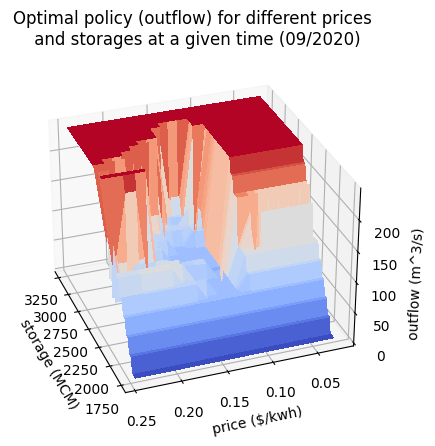

In [507]:
plot_policy(storage_grid,price_grid,policy[2])

<ipython-input-185-7093d5631473>:5: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


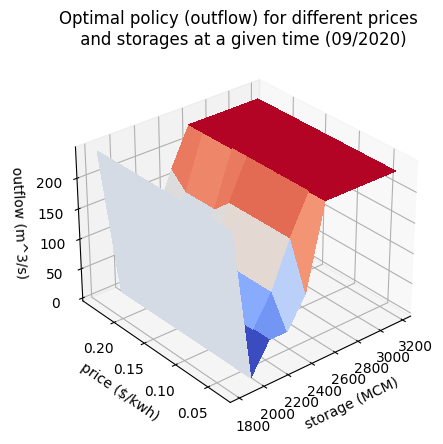

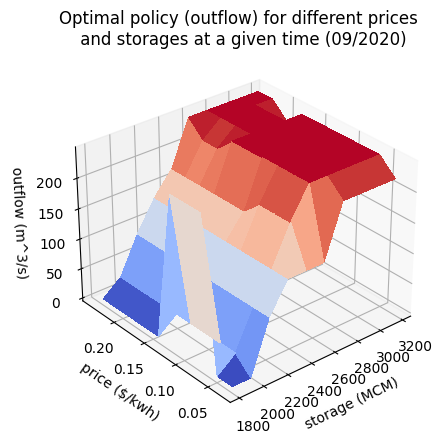

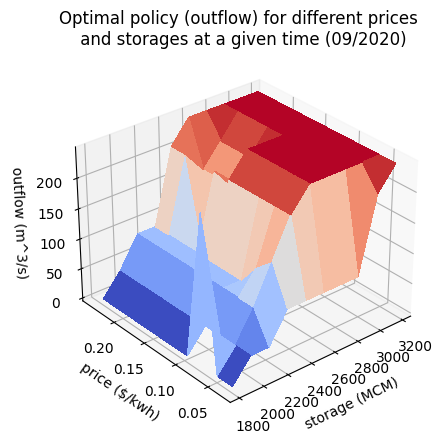

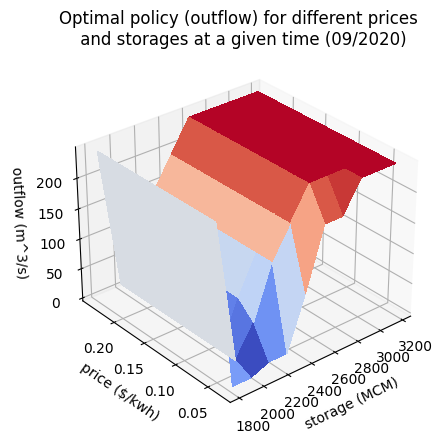

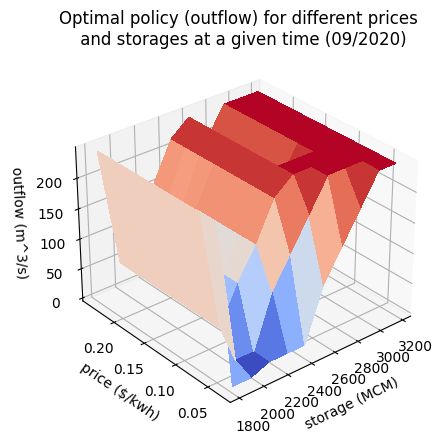

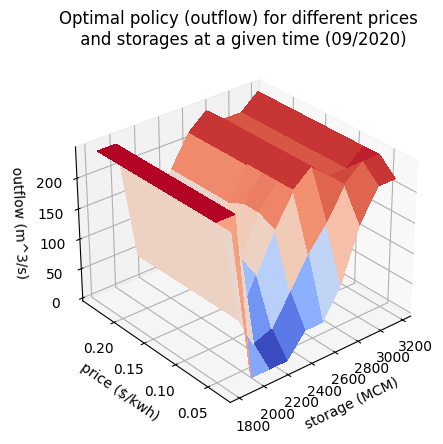

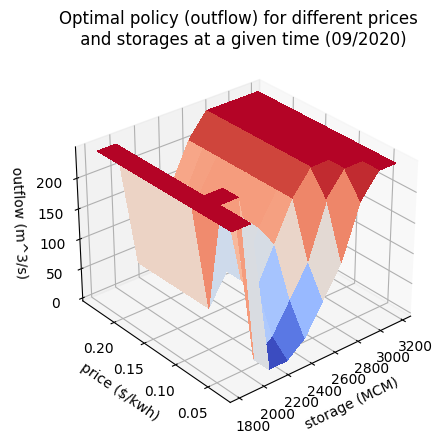

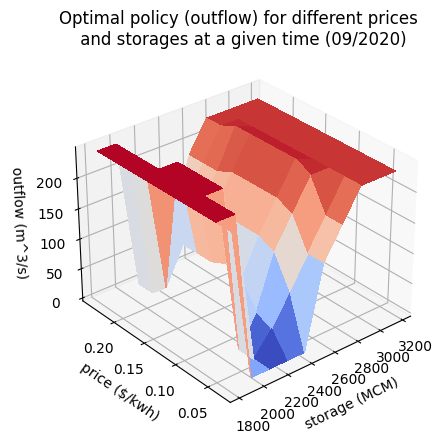

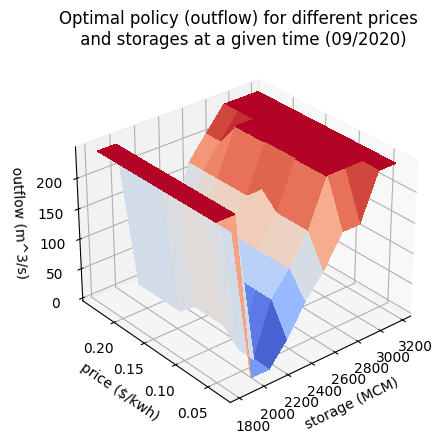

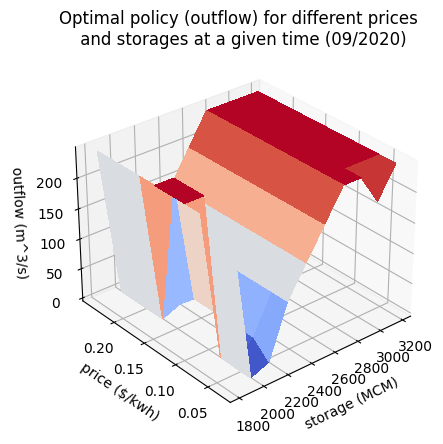

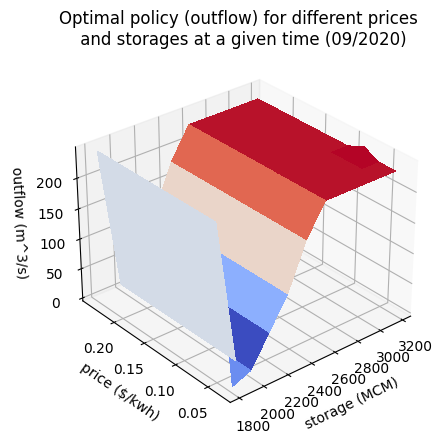

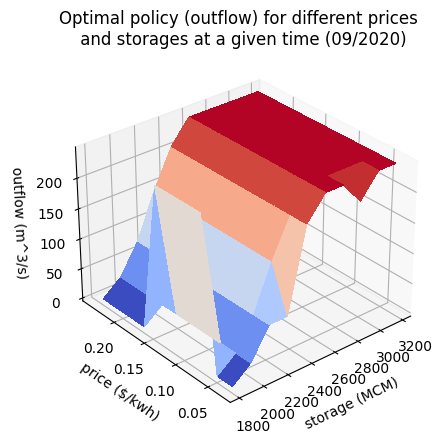

In [186]:
for s in range(12):
    plot_policy(storage_grid,price_grid,policy[s])

In [187]:
# This function has a wide margin for acceleration

def future_payments(V,A,shocks_storage, shocks_price, input_next_storage, input_next_price, price_grid, storage_grid):
    K = len(shocks_storage)
    J = len(shocks_price  )
    
    future_payment = 0

    for j in range(J):
        future_storages = []
        for k in range(K):
            future_storage = next_storage(*input_next_storage, shocks_storage[k]) 
            future_storages.append(future_storage)
            future_price   = next_price(  *input_next_price  , shocks_price[j])
            
#             if future_storage < 2000 or future_storage > 3000:
#                 continue
                
            x = rounding_argument(future_storage, storage_grid)
            y = rounding_argument(future_price  , price_grid)
            future_payment +=  V[x,y] * A[k,j] # adding expected payment
            
        if np.min(future_storages) < 2000 or np.max(future_storages) > 3000:
            for k in range(K):
                future_storage = next_storage(*input_next_storage, shocks_storage[k]) 
                future_price   = next_price(  *input_next_price  , shocks_price[j])

    #             if future_storage < 2000 or future_storage > 3000:
    #                 continue

                x = rounding_argument(future_storage, storage_grid)
                y = rounding_argument(future_price  , price_grid)
                future_payment -=  V[x,y] * A[k,j] # adding expected payment
            

    
    return future_payment

### Working with the policy towards an optimal solution

In [335]:
print(price_grid)
print(storage_grid)

[0.022875 0.028625 0.034375 0.040125 0.045875 0.051625 0.057375 0.063125
 0.068875 0.074625 0.080375 0.086125 0.091875 0.097625 0.103375 0.109125
 0.114875 0.120625 0.126375 0.132125 0.137875 0.143625 0.149375 0.155125
 0.160875 0.166625 0.172375 0.178125 0.183875 0.189625 0.195375 0.201125
 0.206875 0.212625 0.218375 0.224125 0.229875 0.235625 0.241375 0.247125]
[2050. 2150. 2250. 2350. 2450. 2550. 2650. 2750. 2850. 2950.]


In [9]:
def closest_argument(value, array):
    return np.argmin(np.abs(array-value))

In [44]:
def rounding_argument(value, array):
    new = array - value
    new[new > 0 ] = -1e4
    return np.argmax(new)
    

In [337]:
input_storage = ts.storage.values[-1]
input_price   = ts.price.values[-1]

storage_coor = closest_argument(input_storage, storage_grid)
price_coor   = closest_argument(input_price,   price_grid  )

In [140]:
print(input_storage)
print(storage_coor)
print(input_price)
print(price_coor)

2507.876580645161
5
0.142
8


In [240]:
ts.loc[time_0-1,'outflow']

1.4231612903225803

In [488]:
outflow = ts.loc[time_0-1,'outflow']
storage = ts.loc[time_0-1,'storage']

storage_price_outflow = np.zeros((3,S))

for s in range(S):
    
    current_time = time_0 + s
        
    input_next_storage = [model_inflow, ts_forecast.loc[current_time - 1,'inflow'] , model_evaporation, current_time,
                                          storage, outflow, model_storage] # Outflow changed from IV loop
    
    storage = next_storage(*input_next_storage, 0)
    
    price   = next_price(t,ts_forecast.loc[current_time - 1,'price'], 0)
    
    x = closest_argument(storage, storage_grid)
    y = closest_argument(price  , price_grid)
    
    outflow = policy[s,x,y] # (MCM)
    
    storage_price_outflow[0,s] = storage
    storage_price_outflow[1,s] = price
    storage_price_outflow[2,s] = 2.592 * outflow


In [466]:
storage_outflow_price[0,:]

array([2648.10496998, 2225.27566335, 2079.61201949, 2110.60912763,
       2359.07635138, 2026.34946153, 1956.01810467, 1998.39287942,
       2059.44134689, 2030.1852985 , 2075.53573455, 2118.05285761,
       2033.86862921, 2124.57578847, 2043.585339  , 2011.32679377,
       2259.84676841, 1927.1310833 , 1983.81010641, 2026.18538669,
       2023.72996153, 2057.97793595, 2103.32837685, 2209.34950093])

In [470]:
storage_outflow_price[1,:]

array([0.13869229, 0.13710502, 0.14050353, 0.14770597, 0.15787713,
       0.16843154, 0.17639489, 0.17930365, 0.17633043, 0.16826646,
       0.15858418, 0.15030236, 0.14487082, 0.14443142, 0.14696683,
       0.15172352, 0.15737779, 0.16254858, 0.1658684 , 0.16642891,
       0.16415446, 0.16000393, 0.15508234, 0.15070439])

In [469]:
storage_outflow_price[2,:]

array([635.04 , 381.024, 190.512,   0.   , 444.528, 127.008,   0.   ,
         0.   , 127.008, 127.008, 190.512, 254.016, 127.008, 317.52 ,
       254.016,   0.   , 444.528,   0.   ,   0.   ,  63.504,  63.504,
       127.008, 127.008, 444.528])

In [306]:
ts_forecast.loc[495,'inflow']

83.07485417194728

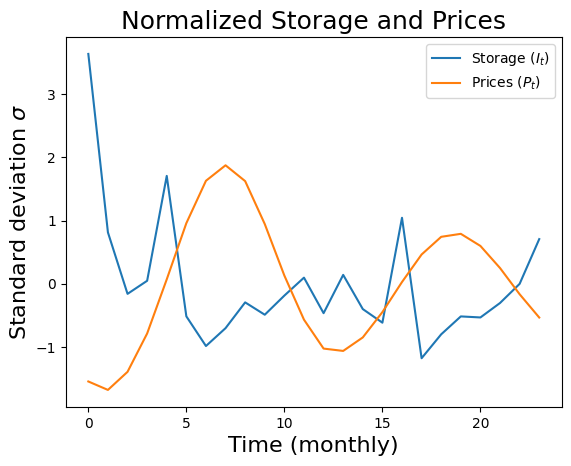

In [514]:
plt.plot((storage_price_outflow[0,:]-(np.mean(storage_price_outflow[0,:])))/np.std(storage_price_outflow[0,:]),label = 'Storage ($I_t$)')
plt.plot((storage_price_outflow[1,:]-(np.mean(storage_price_outflow[1,:])))/np.std(storage_price_outflow[1,:]),label = 'Prices ($P_t$)')
plt.legend()
plt.ylabel('Standard deviation $\sigma$',fontdict={'size': 16})
plt.xlabel('Time (monthly)',fontdict={'size': 16})
plt.title('Normalized Storage and Prices',fontdict={'size': 18})
plt.savefig('Figures/storage_policy.pdf', format='pdf')
plt.show()

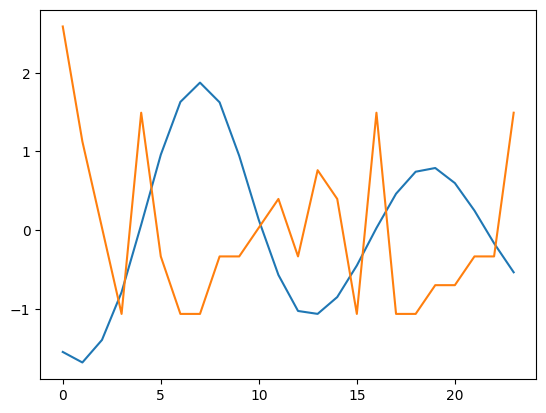

In [492]:
plt.plot((storage_price_outflow[1,:]-(np.mean(storage_price_outflow[1,:])))/np.std(storage_price_outflow[1,:]))
plt.plot((storage_price_outflow[2,:]-(np.mean(storage_price_outflow[2,:])))/np.std(storage_price_outflow[2,:]))
plt.show()

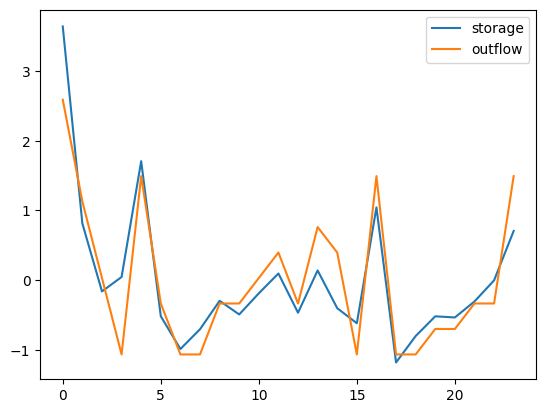

In [494]:
plt.plot((storage_price_outflow[0,:]-(np.mean(storage_price_outflow[0,:])))/np.std(storage_price_outflow[0,:]), label='storage')
plt.plot((storage_price_outflow[2,:]-(np.mean(storage_price_outflow[2,:])))/np.std(storage_price_outflow[2,:]), label='outflow')
plt.legend()
plt.show()

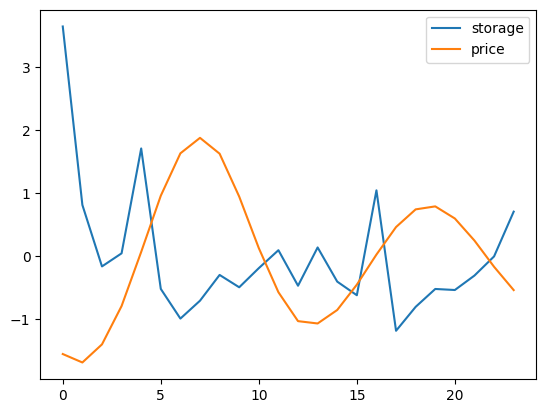

In [495]:
plt.plot((storage_price_outflow[0,:]-(np.mean(storage_price_outflow[0,:])))/np.std(storage_price_outflow[0,:]), label='storage')
plt.plot((storage_price_outflow[1,:]-(np.mean(storage_price_outflow[1,:])))/np.std(storage_price_outflow[1,:]), label='price')
plt.legend()
plt.show()

In [279]:
ts.loc[time_0-1,'storage']

2507.876580645161

In [283]:
2.592 * ts_forecast.loc[current_time - 1,'inflow']

113.34891251612903

In [284]:
next_storage(*input_next_storage, 0)

2648.104969975169

In [287]:
2.592 * model_inflow(current_time,ts_forecast.loc[current_time - 1,'inflow']) + 2507

2653.292026992198